# softmax回归从零开始实现

In [1]:
import torch
from IPython import display
from d2l import torch as d2l
import torchvision
from torch.utils import data
from torchvision import transforms

d2l.use_svg_display()

## 读取数据集

In [2]:
# 我们可以通过框架中的内置函数将Fashion-MNIST数据集下载并读取到内存
# 通过ToTensor实例将图像数据从PIL类型转换为32位浮点数格式
# 并且除以255是的所有像素的数据均在0，1之间

In [6]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=False)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=False)

Fashion-MNIST由10个类别的图像组成，每个类别由训练数据集（train dataset）中的6000张图像和测试数据集（test dataset）中的1000张图像组成。因此，训练集和测试集分别包含60000和10000张图像。测试数据集不会用于训练，只用于评估模型性能。

In [7]:
len(mnist_train), len(mnist_test)

(60000, 10000)

每个输入图像的高度和宽度均为28像素。数据集由灰度图像组成，其通道数为1。为了简洁，本书将高
度h像素、宽度w像素图像的形状记为$h × w$或$（h,w）$

In [8]:
print(mnist_train[0][0].shape)

torch.Size([1, 28, 28])


In [9]:
def get_fashion_mnist_labels(labels):
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 如果输入参数img是图片张量
            ax.imshow(img.numpy())
        else:
            # PIL 图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

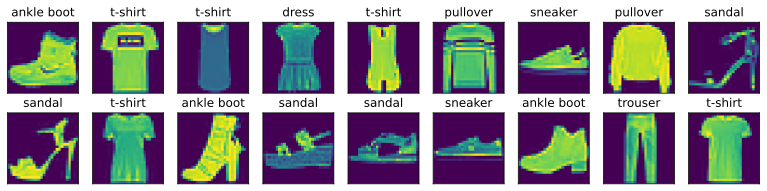

In [10]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

## 读取小批量

In [11]:
batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers())
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f}sec'

'2.23sec'

## 整合所有组件

现在我们定义load_data_fashion_mnist函数，用于获取和读取Fashion-MNIST数据集。这个函数返回训练集
和验证集的数据迭代器。此外，这个函数还接受一个可选参数resize，用来将图像大小调整为另一种形状。

In [12]:
def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans) #Compose用来定义一个张量变换操作序列
    mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=False)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,num_workers=get_dataloader_workers()))


In [13]:
# 通过指定resize参数来测试load_data_fashion_mnist函数的图像大小调整功能
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


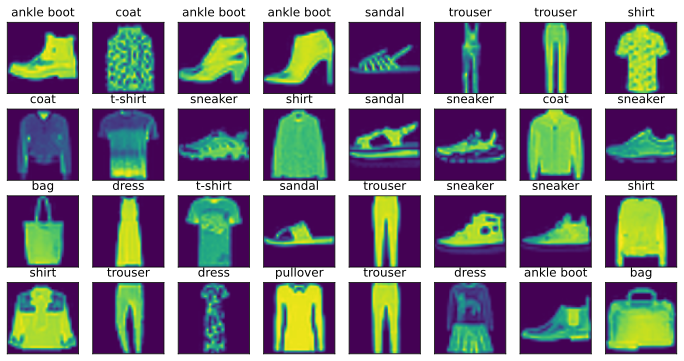

In [14]:
X, y = next(iter(train_iter))
show_images(X.reshape(32, 64, 64), 4, 8, titles=get_fashion_mnist_labels(y));

## Softmax回归从0开始实现

In [15]:
from IPython import display
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size=batch_size)

### 初始化模型参数
- 和之前线性回归的例子一样，这里的每个样本都将用固定长度的向量表示。原始数据集中的每个样本都是28×
28的图像。本节将展平每个图像，把它们看作长度为784的向量。在后面的章节中，我们将讨论能够利用图像
空间结构的特征，但现在我们暂时只把每个像素位置看作一个特征
- 在softmax回归中，我们的输出与类别一样多，因为我们的数据集有10个类别，所以网络输出维度是10。因此权重将构成一个784 × 10 的矩阵
- 偏置将构成一个1 × 10 的行向量
- 我们使用正态分布初始化我们的权重 W， 偏执初始化为0

In [16]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size = (num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

实现softmax由三个步骤组成：
1. 对每个项求幂（exp）
2. 对每一行求和，小批量中每个样本是一行，得到每个样本的规范化常数
3. 将每一行除以其规范化常数，确保结果的和为1

In [15]:
def softmax(O):
    """
    参数使用字母O来和书中一致
    :param O: 为经过权重矩阵和偏重矩阵处理后的输出值
    :return: 各类别的估计概率
    """
    O_exp = torch.exp(O)
    normalize_partition = O_exp.sum(1, keepdim = True)
    return O_exp / normalize_partition

In [16]:
# 我们来尝试softmax函数，假设输出是2个样本，5个特征
O = torch.normal(0, 1, (2, 5))
O_prob = softmax(O)
O, O_prob

(tensor([[ 1.1628,  0.0399,  2.0296,  1.9268, -0.1231],
         [ 0.5809,  1.9417, -0.0810, -1.5229,  0.3390]]),
 tensor([[0.1632, 0.0531, 0.3883, 0.3503, 0.0451],
         [0.1582, 0.6168, 0.0816, 0.0193, 0.1242]]))

### 定义模型
定义softmax操作之后，我们可以实现softmax回归模型

In [17]:
def softmax_net(X, W, b):
    O = torch.matmul(X, W) + b
    return softmax(O)

### 定义损失函数
交叉熵采用真实标签预测概率的负对数似然，为了提高运算速度，我们尽量不适用循环，这里我们采用一个小技巧
1. 相较于独热向量， 下面y的真实值使用每个样本真实类别的标号
2. y_hat为经过softmax处理后的样本属于各个类别的预测概率，这里我们假设了一共有6个样本5个输出类别
3. 使用表达式y_hat[选中的行索引， 选中的列索引] 我们可以选择出真是样本标签的预测概率
4. 再结合argmax函数，argmax函数可以返回一行中数值最大的样本列索引，我们可以得到预测最大的概率所属类别和大小
5. 由以上方法我们可以定义交叉熵损失函数和预测的准确率

In [18]:
# little trick
y = torch.tensor([0, 1, 1, 3, 2, 4])
y_hat = softmax(torch.normal(0, 1, (6, 5)))
y_hat, y_hat[range(len(y)), y]

(tensor([[0.0349, 0.3669, 0.0786, 0.0709, 0.4488],
         [0.0831, 0.1520, 0.1638, 0.2561, 0.3451],
         [0.3237, 0.4410, 0.0481, 0.0876, 0.0997],
         [0.0475, 0.0195, 0.0072, 0.0010, 0.9248],
         [0.1455, 0.2844, 0.3693, 0.0992, 0.1016],
         [0.6512, 0.1058, 0.0880, 0.0696, 0.0854]]),
 tensor([0.0349, 0.1520, 0.4410, 0.0010, 0.3693, 0.0854]))

In [19]:
y_hat.argmax(axis = 1)

tensor([4, 4, 1, 4, 2, 0])

In [20]:
y_hat[range(len(y)), y_hat.argmax(axis = 1)]

tensor([0.4488, 0.3451, 0.4410, 0.9248, 0.3693, 0.6512])

回忆交叉熵损失函数的表达式
$$ l(\boldsymbol{y}, \boldsymbol{\hat{y}}) = - \sum_{j = 1}^q y_j \log{\hat{y_j}}$$
其中输出特征数一共有$q$个，当$\boldsymbol{y}$作为独热向量时，只有预测正确的类是1其他为0，换句话说上式中针对每个样本（矩阵中的一行）我们只选择           **_真实类所在列_** 的         **_预测概率_**       取负对数之后求和
这个真实值的独热向量我们可以使用真实输出类别的标号组成的一个一维的，长度为样本数的向量

In [21]:
def cross_entropy(y_hat, y):
    """
    实现交叉熵损失
    :param y_hat: 预测值矩阵
    :param y: 长度为样本数的一维真实值向量
    :return: 交叉熵损失
    """
    loss = -torch.log(y_hat[range(len(y_hat)), y])
    return loss

In [22]:
cross_entropy(y_hat, y)

tensor([3.3560, 1.8841, 0.8187, 6.8802, 0.9961, 2.4607])

### 分类精度

In [23]:
def accuracy(y_hat, y):
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1: # 如果预测值向量维度大于1而且列数大于1
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y #此时y_hat已经变成了预测概率最高的类的类别标号
    # cmp是一个布尔值组成的向量
    return float(cmp.type(y.dtype).sum())
accuracy(y_hat, y)/len(y)

0.3333333333333333

In [ ]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
        
    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [38]:
def evaluate_accuracy(net, data_iter):
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval() # 把模型设置为评估模式
    metric = Accumulator(2) # 正确预测数，预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

0.3333333333333333